# Time-series prediction in PyTorch
### Requirements:
Pytorch build (1.7.1) for python (I have version 3.8.3). I used the Conda package. Installation details here: https://pytorch.org/get-started/locally/  
Matplotlib and numpy will also be needed. Sklearn is optional but nice if you want to avoid writing an MSE by hand.

### step 0: imports 

In [1]:
import torch
import torch.nn as nn                    # the basic building blocks for your nets
import torch.nn.functional as F          # some lower-level functions kept here
import torch.optim as optim              # we'll use this for optimization of the net

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# EXAMPLE 1: 
## Using one continuous signal to predict another with a fully-connected network

Here, we'll start with the easiest possible time-series case to get a good feeling for how PyTorch works. The simplest example I could come up with is using a single noisy sine wave to predict another single noisy cosine wave. These signals are easy to visualize, easy to debug, and easy to measure the performance of our network. The step-by-step is:
1. Create the data (training and test sets)
2. Convert the data into tensors
3. Build the network
4. Train the network
5. Evaluate the network using test data and plot the results

### Ex1.Step1: Create the data
In the first step, we'll make one input signal (a noisy sine wave) and one output signal (a noisy cosine). We'll be using the sine wave as an input to the model to predict the cosine, which seems like a trivial problem. We'll need to create separate data for our training set (what we use to optimize our model) and our testing set (how we measure the accuracy of our model's performance on new data). 

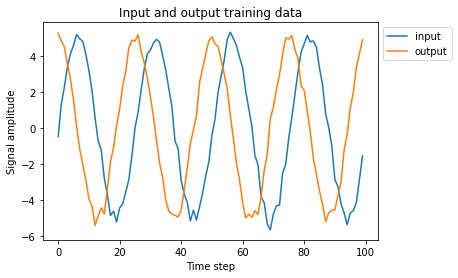

In [2]:
t = np.arange(0,100,1)                    # create a time vector of length 100, starting from 0, in steps of 1
f = 0.25                                  # pick a frequency you like
A = 5                                     # and an amplitude for your waves

# make the sine and cosine waves and add some random noise of length 100 in the range of 0 to 0.25
data_in_train = A * np.sin(f*t) + np.random.normal(0, 0.25, 100)
data_out_train = A * np.cos(f*t) + np.random.normal(0, 0.25, 100)

data_in_test = A * np.sin(f*t) + np.random.normal(0, 0.25, 100)
data_out_test = A * np.cos(f*t) + np.random.normal(0, 0.25, 100)

# visualize the training data you've created:
plt.plot(data_in_train[0:100])
plt.plot(data_out_train[0:100])
plt.title('Input and output training data')
plt.xlabel('Time step')
plt.ylabel('Signal amplitude')
plt.legend(['input', 'output'], bbox_to_anchor=(1,1), loc="upper left") # put the legend on the right of the plot
plt.show()

### Ex1.Step2: Convert the data to tensors 
Tensors are the data structure used in building these nets. Each tensor must be of a single data type. If you've worked with numpy arrays, tensors are a breeze: you can use almost all the same operations in almost the same way. Documentation here: https://pytorch.org/docs/stable/tensors.html

In [3]:
# so our tensors play nice with our model without us having to cast new variable types, set the default to float64
torch.set_default_dtype(torch.float64)

t_data_in_train = torch.tensor(data_in_train)
t_data_out_train = torch.tensor(data_out_train)
t_data_in_test = torch.tensor(data_in_test)
t_data_out_test = torch.tensor(data_out_test)

# check the shape of our tensors:
print('Tensor size: ', np.shape(t_data_in_train))

Tensor size:  torch.Size([100])


#### And reshape the tensors to be the right size
We have our tensors, are we good to go? Sorry, not yet. A bit of pedantry here in the way PyTorch accepts (and expects) tensors: based on whether we are feeding our tensor into a _fully connected_ layer or a _convolutional layer_ , the layers will expect different arguments in a different order. It's okay if this seems vague right now. Here is a nice cheat-sheet to some dimensions we could encounter:    

torch.Size([100])   
**1D:** [batch size]  
_Use for: target labels, predictions, outputs_  

torch.Size([1,100])   
**2D:** [batch size, number of features]  
_Use for: input to a linear layer_  

torch.Size([10, 1, 2048])   
**3D:** [batch size, channels, number of features (i.e. height x width)]  
_Use for: input to a 1D Convolutional layer_  **OR**  
**3D:** [sequence_length, batch_size, number of features]  
_Use for: input to an RNN_  

torch.Size([10, 3, 28, 28])   
**4D:** [batch size, channels, height, width]  
_Use for: input to a 2D convolutional layer: 10 RGB (3-channel) images sized 28 by 28_  

(A great guide on tensor size can be found at: https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd)

#### So what does this mean for our model?
Since we'll be using a simple fully-connected model at first, with just a few linear layers, we want our input shape to be:  
[1,100] or "one batch (1 sample) of length 100"

In [4]:
# use the unsqueeze function to add a dimension of size 1 added to the specified dimension (here, in dim=0)

t_data_in_train = torch.unsqueeze(t_data_in_train, dim = 0) 
t_data_out_train = torch.unsqueeze(t_data_out_train, dim = 0)
t_data_in_test = torch.unsqueeze(t_data_in_test, dim = 0) 
t_data_out_test = torch.unsqueeze(t_data_out_test, dim = 0)

# check the shape of our tensors after unsqueezing:
print('Tensor size: ', np.shape(t_data_in_train))

Tensor size:  torch.Size([1, 100])


### Ex1.Step3: Build the network
This is the creative part! To keep this guide short, I decided to skip a piece-wise explanation of running a forward propagation, backward proppagation, and updating weights: a decent beginner's tutorial on this can be found at https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html, but if you trust me, we'll jump straight into defining a class for our net. This is the simplest kind of object-oriented programming.   

Our net will consist of 3 fully connected layers, and ReLU activation (a rectified linear unit) which is a fancy way of saying that each neuron in our network will use a ReLU function to map its inputs to outputs. Here's how we'll make our net:

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # now we play hidden-layer ping-pong: the number of hidden layers OUT needs to equal the number IN to the next layer
        
        self.fc1 = nn.Linear(100,5)  # we input the size of our feature (length 100) and decide on 5 hidden layers
        self.fc2 = nn.Linear(5,10)   # the number of hidden layers out from the last step (5) should be the same as input (5)
        self.fc3 = nn.Linear(10,100) # and we set our final output to the length of our output signal (also 100)
        
        
    # we have to define the forward method within the nn.Module itself    
    def forward(self, x):
        x = F.relu(self.fc1(x))      # we use a ReLU activation for each Linear layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)              # and return just the output signal
        return x
        
net = Net()

# visualize what our network looks like: it should have 3 Linear layers in total
print(net) 

Net(
  (fc1): Linear(in_features=100, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=100, bias=True)
)


### Ex1.Step4: Train the network
We've built our net, but we need to teach it how to convert an input sine wave to an output cosine. We'll train for 1000 iterations (which is overkill of course), and in each iteration we'll put the training data in [1x100], cascade through the 3 linear layers with a ReLU activation for each neuron in the layer, calculate the loss (mean-squared error here) between the model's output and the real cosine we wanted, backpropagate the weights given that loss, and move our optimizer one step forward. Then repeat until we've trained for all iterations. 

In order to track how well our model is training, we'll print out the MSE loss every 100 steps (so we can sanity-check and make sure the model is improving every time) and plot the total learning curve (loss decrease) once we're done.  


0.08718543087489476
0.034407293142101204
0.007219766119145282
0.0009825061845464538
0.00011262056297076
1.2640403159950632e-05
1.4134273446856698e-06
1.499743231166664e-07
1.4309073902724258e-08
1.1795558388203218e-09
Finished Training


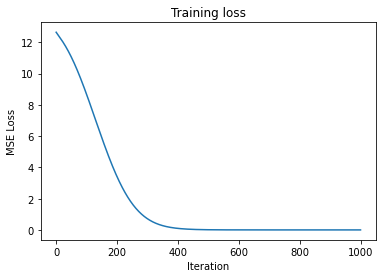

In [6]:
# pick an optimzer (Adam learns the optimal learning rate, so it's a common one to use)

optimizer = optim.Adam(net.parameters(), lr=0.002) 
# pick a loss function that suits the data (continuous time-series data work well with MSE)
criterion = nn.MSELoss()

# initialize the variable we'll use to store overall loss
model_loss = [];

# let's train the net for 1000 iterations (overkill, considering how simple the function is)
for epoch in range(1000):
    # reset the running loss that will be printed as we train our model
    running_loss = 0.0 
    
    # reset the gradient values 
    optimizer.zero_grad()
    
    # put the training data into the net 
    outputs= net(t_data_in_train)
    
    # calculate the MSE Loss using the ground-truth training signal output
    loss = criterion(outputs, t_data_out_train)
    
    # backpropagate weights
    loss.backward()
    
    # move forward one step in the optimization
    optimizer.step()
    
    # save the MSE loss value so we can plot later (and we want to detach it with .item() so we don't run out of memory)
    model_loss.append(loss.item())
    
    # print the current loss:
    running_loss += loss.item()
    if epoch % 100 == 99:          # every 100 steps
        print(running_loss/100)    # print the running loss
        running_loss = 0.0
print('Finished Training')


# plot the loss over training iterations:
plt.plot(model_loss)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.show()

As you can see, our training loss went down over time! That's what we want to see. After a certain number of iterations, our model stopped improving, so it's pretty clear that training it for 1000 iterations wasn't necessary. Let's see how the net does on new data:

### Ex1.Step5: Test the network on new data
Above, we had made a tensor for our testing data. In practice, you'd probably have several test inputs, but for easy visualization we can stick with just one. Let's feed the input sine to the net, and compare its output to our ground-truth cosine. 

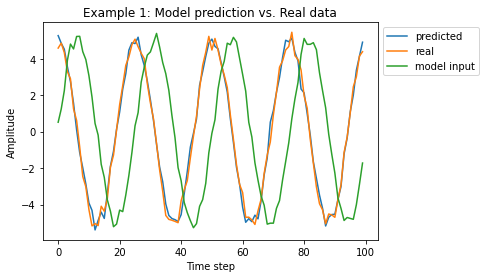

In [7]:
# use the trained net to predict an output for the input test data
model_out = net(t_data_in_test)

# to plot the data, we first collapse it back to a [100] length tensor
model_out = model_out.view(-1)
# then we need to "detach" it from a tensor
model_out = model_out.detach().numpy()
plt.plot(model_out)

# and the same for the ground-truth data:
test_out = t_data_out_test.view(-1)
test_out = test_out.detach().numpy()
plt.plot(test_out)

# and let's see what the input signal was as well:
test_in = t_data_in_test.view(-1)

# plot:
plt.plot(test_in.detach().numpy())
plt.title('Example 1: Model prediction vs. Real data')
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.legend(['predicted', 'real', 'model input'], bbox_to_anchor=(1,1), loc="upper left")
plt.show()

It looks great! We've successfully built a fully-connected network that was able to take a sine wave as an input and predict the cosine wave really well. We can compute the MSE between our predicted signal and real signal to check its accuracy:

In [8]:
print('Test error is: ', mean_squared_error(model_out, test_out))

Test error is:  0.1268862165621793


Looks good. Not as good as our training accuracy, but that's to be expected! We're probably fitting a little too closely to the exact kind of noise present in our training signals, and leaving our model brittle to new types of data. How could we improve how robust our model is? A straightforward way is to include more training data, with more varieties of noise. Is the model we built capable of accepting several batches of sine waves? It turns out, yes!  

Let's check it out:

# Example 2: Training our model with many batches of inputs 
### Ex2.Step1: Create the data
Here, we'll make a batch of 20 sine waves as input to predict 20 cosines 

In [9]:
# make training data consisting of 20 batches, each length 100
data_in_train = []
data_out_train = []
for i in range(20):
    sin = A * np.sin(f*t) + np.random.normal(0, 0.25, 100)
    cos = A * np.cos(f*t) + np.random.normal(0, 0.25, 100)
    data_in_train.append(sin)
    data_out_train.append(cos)

# we'll still test on a single sine and cosine
data_in_test = A * np.sin(f*t) + np.random.normal(0, 0.25, 100)
data_out_test = A * np.cos(f*t) + np.random.normal(0, 0.25, 100)

### Ex2.Step2: Convert data to tensors
As before, we'll need to make our inputs into tensors. This time, we won't need to unsqueeze to add a 1 in the 0-dimension because we'll already have 20 batches (our array is already 20x100)

In [10]:

t_data_in_train = torch.tensor(data_in_train)
t_data_out_train = torch.tensor(data_out_train)
t_data_in_test = torch.tensor(data_in_test)
t_data_out_test = torch.tensor(data_out_test)

# check the shape of our tensors:
print('Tensor size: ', np.shape(t_data_in_train))

Tensor size:  torch.Size([20, 100])


### Ex2.Step3: Build the network
We don't have to rewrite our network because it already exists as a class, and we don't need to make any modifications to it at all. But we do want to reset or reinitialize our model so that we can train it from scratch:

In [15]:
net = Net()
print(net) 

Net(
  (fc1): Linear(in_features=100, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=100, bias=True)
)


### Ex2.Step4: Train the network
Just like before, we'll train the network using the same parameters. This time, we'll have a batch of 20 inputs, so you can expect that the training will take a little longer.

0.0019008892598259264
0.0005764410259275343
0.000574874314269114
0.0005736618529404719
0.0005726413413683778
0.0005717481843459811
0.0005709613921393649
0.000570274233752531
0.0005696810650059659
0.0005691745271038597
Finished Training


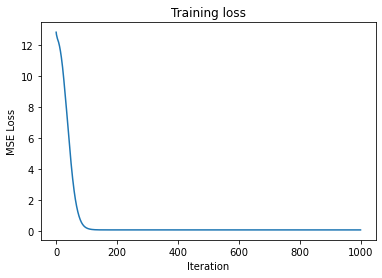

In [16]:
optimizer = optim.Adam(net.parameters(), lr=0.002) 
criterion = nn.MSELoss()

model_loss = [];

for epoch in range(1000):
    running_loss = 0.0 
    
    optimizer.zero_grad()
    
    outputs= net(t_data_in_train)
    loss = criterion(outputs, t_data_out_train)
    loss.backward()
    optimizer.step()
    
    model_loss.append(loss.item())
    
    running_loss += loss.item()
    if epoch % 100 == 99:          
        print(running_loss/100)    
        running_loss = 0.0
print('Finished Training')


plt.plot(model_loss)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.show()

### Ex2.Step5: Test the network on new data 
As before, we'll evaluate how well our model can predict unseen data:

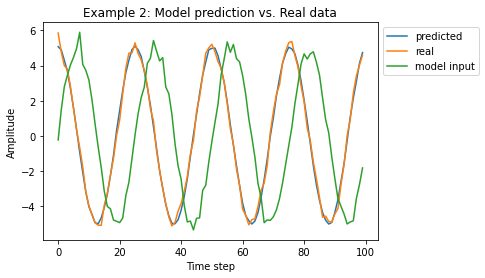

In [17]:
# model predictions:
model_out = net(t_data_in_test)
model_out = model_out.view(-1)
model_out = model_out.detach().numpy()
plt.plot(model_out)

# ground-truth data:
test_out = t_data_out_test.view(-1)
test_out = test_out.detach().numpy()
plt.plot(test_out)

# input signal:
test_in = t_data_in_test.view(-1)

# plot:
plt.plot(test_in.detach().numpy())
plt.title('Example 2: Model prediction vs. Real data')
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.legend(['predicted', 'real', 'model input'], bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [18]:
print('Test error is: ', mean_squared_error(model_out, test_out))

Test error is:  0.05974708716563893


As you can see, the MSE went down between Example 1 and 2 -- this is likely because we've included a larger variety of samples with different kinds of noise, and now our model isn't overfitting to the exact kind of noise seen in the training data. This fits with our intuition that more data = more better. If you'd like, you can play around with the linear layers by changing the number of layers (make sure each fc has a relu in the forward method!) or the amount of hidden neurons to see if you can get the MSE to converge more quickly or the test accuracy to increase.  

Let's take this up one level in complexity: how would we need to change our model if we had two channels for each batch? Say that we had 2 sine waves of different amplitudes, and we wanted to predict a single cosine? 

# Example 3: Training a network with two channels in each batch
Here, we'll again make 20 batches of input data, each containing 2 sine waves each of length 100.
### Ex3.Step1: Create the data

In [19]:
# make training data consisting of 20 batches, each length 100
data_in_train = []
data_out_train = []
for i in range(20):
    sin1 = A * np.sin(f*t) + np.random.normal(0, 0.25, 100)
    sin2 = A * np.sin(f*t) + np.random.normal(0, 0.25, 100)
    cos = A * np.cos(f*t) + np.random.normal(0, 0.25, 100)
    data_in_train.append([sin1, sin2])
    data_out_train.append(cos)

# check the shape of the training data:
print('Training data shape: ', np.shape(data_in_train))

# we'll test on 2 sines and 1 cosine
data_in_test = [A * np.sin(f*t) + np.random.normal(0, 0.25, 100), A * np.sin(f*t) + np.random.normal(0, 0.25, 100)]
data_out_test = A * np.cos(f*t) + np.random.normal(0, 0.25, 100)

Training data shape:  (20, 2, 100)


Great, our training data is now sized (20,2,100) which corresponds to 20 batches, 2 channels, length 100. Now we can convert the data to tensors:
### Ex3.Step2: Convert data to tensors
Because we're going straight from our arrays that are already sized correctly to the same shape of tensor, we don't have to worry about rearranging or squeezing. For reference, here is a good guide on how to manipulate tensors (concatenating, moving dimensions around, squeezing and so on): https://medium.com/towards-artificial-intelligence/working-with-pytorch-tensors-2ce272953b37

In [20]:
t_data_in_train = torch.tensor(data_in_train)
t_data_out_train = torch.tensor(data_out_train)
t_data_in_test = torch.tensor(data_in_test)
t_data_out_test = torch.tensor(data_out_test)

# check the shape of our tensors:
print('Tensor size: ', np.shape(t_data_in_train))
print('Tensor size: ', np.shape(t_data_in_test))

Tensor size:  torch.Size([20, 2, 100])
Tensor size:  torch.Size([2, 100])


Can you see what we did wrong above?  

Our training input tensor is 3D, but our testing input tensor is only 2D. If we make our network expect a 3D input but feed it a 2D tensor, it won't be happy with us. To us, it's implicit that we only have one batch that we're using to test the model, but we need to make that explicit for PyTorch. We'll use unsqueeze here again: 

In [21]:
t_data_in_test = torch.unsqueeze(t_data_in_test, dim = 0) 

# and check the shape to make sure we did it right:
print('Tensor size: ', np.shape(t_data_in_test))

Tensor size:  torch.Size([1, 2, 100])


### Ex3.Step3: Build the network
We won't be able to use the same network architecture as we did previously. Try it for yourself by running the optimizer using the new set of t_data_in_train. You'll get an error that looks something like:    
 
**UserWarning: Using a target size (torch.Size([20, 100])) that is different to the input size (torch.Size([20, 2, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.**  

Instead, we'll have to flatten our input tensor so that it "fits" into a fully connected 1D layer. We can do this by "stacking" the two input sine waves on top of each other for every batch: in other words, combining both 100-length sine waves into a single 200-length input, 20 times. We'll use .view() to do this, and we can put it right into our network class, in the forward method:

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # here, our linear layer will have an input of 200, not 100 as before:
        self.fc1 = nn.Linear(200,5)  
        self.fc2 = nn.Linear(5,10)   
        self.fc3 = nn.Linear(10,100) # but the output remains 100
        
          
    def forward(self, x):
        # we have to flatten our 20x2x100 to a 20x200:
        x = x.view(x.size(0),-1)     # x.size(0) is 20, and -1 is a shortcut for "figure out the other number for me please!"
        
        # the rest proceeds as before:
        x = F.relu(self.fc1(x))      
        x = F.relu(self.fc2(x))
        x = self.fc3(x)              
        return x
        
net = Net()
print(net) 

Net(
  (fc1): Linear(in_features=200, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=100, bias=True)
)


### Ex3.Step4: Train the network:


0.00111071821415971
0.0005923956285104396
0.0005886295461846748
0.0005860560225593956
0.0005843525449281449
0.0005832656933718662
0.0005826018293401571
0.0005822136324314295
0.0005819950476654253
0.0005818753853706981
Finished Training


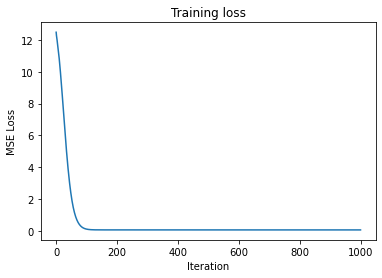

In [23]:
optimizer = optim.Adam(net.parameters(), lr=0.002) 
criterion = nn.MSELoss()

model_loss = [];

for epoch in range(1000):
    running_loss = 0.0 
    
    optimizer.zero_grad()
    
    outputs= net(t_data_in_train)
    loss = criterion(outputs, t_data_out_train)
    loss.backward()
    optimizer.step()
    
    model_loss.append(loss.item())
    
    running_loss += loss.item()
    if epoch % 100 == 99:          
        print(running_loss/100)    
        running_loss = 0.0
print('Finished Training')


plt.plot(model_loss)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.show()

### Ex3.Step5: Test the network on testing data: 

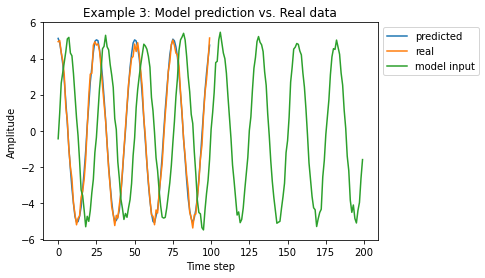

In [24]:
model_out = net(t_data_in_test)

# to plot the data, we first collapse it back to a [100] length tensor
model_out = model_out.view(-1)
# then we need to "detach" it from a tensor
model_out = model_out.detach().numpy()
plt.plot(model_out)

# and the same for the ground-truth data:
test_out = t_data_out_test.view(-1)
test_out = test_out.detach().numpy()
plt.plot(test_out)

# and let's see what the input signal was as well:
test_in = t_data_in_test.view(-1) # (this will collapse to a [200] length, because we have two sines as input)
plt.plot(test_in.detach().numpy())
plt.title('Example 3: Model prediction vs. Real data')
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.legend(['predicted', 'real', 'model input'], bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [25]:
print('Test error is: ', mean_squared_error(model_out, test_out))

Test error is:  0.0716271961189906


Now, we have a good intuition for how to use an input with 2 features to predict a single time-series output. How would we need to change the model from the previous example to predict an output with 2 channels? 

# Example 4: Training a model with several input and several output channels
In this example, our two input channels (the two sine waves) are both relevant in predicting each of the 2 different (cosine wave) outputs, but neither of the two outputs are related to each other. In practice, this could look something like the temperature of two different sensors being used to predict the grow rate of a plant and humidity of the ambient air (and you'd assume that the grow rate and humidity are independent). This is a simplification of plant growing complexity, but I hope you understand how it motivates how we build this network: the inputs will be combined to predict two different outputs that each depend on the two input in their own unique way.  
Of course, you could also train two separate networks, where you predict the grow rate and humidity separately; in practice however, when deploying nets on time-series data, it's usually most computationally efficient to make do with the smallest number of nets you can get away with. 

As before, we'll make our training data contain 20 batches, but this time include 2 output cosine wave channels:
 
### Ex4.Step1: Create the data

In [26]:
# make training data consisting of 20 batches, each length 100
data_in_train = []
data_out_train = []
for i in range(20):
    sin1 = A * np.sin(f*t) + np.random.normal(0, 0.25, 100)
    sin2 = A * np.sin(f*t) + np.random.normal(0, 0.25, 100)
    cos1 = A * np.cos(f*t) + np.random.normal(0, 0.25, 100)
    cos2 = A * np.cos(f*t) + np.random.normal(0, 0.25, 100)
    data_in_train.append([sin1, sin2])
    data_out_train.append([cos1, cos2])

# check the shape of the training data:
print('Training data shape: ', np.shape(data_in_train))

# we'll test on 1 batch of 2 sines and 2 cosine
data_in_test = [A * np.sin(f*t) + np.random.normal(0, 0.25, 100), A * np.sin(f*t) + np.random.normal(0, 0.25, 100)]
data_out_test = [A * np.cos(f*t) + np.random.normal(0, 0.25, 100), A * np.cos(f*t) + np.random.normal(0, 0.25, 100)]

Training data shape:  (20, 2, 100)


### Ex4.Step2: Convert data to tensors

In [29]:
t_data_in_train = torch.tensor(data_in_train)
t_data_out_train = torch.tensor(data_out_train)
t_data_in_test = torch.tensor(data_in_test)
t_data_out_test = torch.tensor(data_out_test)

# remember to add that 1x dimension out front to signify our single testing batch
t_data_in_test = torch.unsqueeze(t_data_in_test, dim = 0) 

# check the shape of our tensors:
print('Tensor size: ', np.shape(t_data_in_train))
print('Tensor size: ', np.shape(t_data_in_test))

Tensor size:  torch.Size([20, 2, 100])
Tensor size:  torch.Size([1, 2, 100])


### Ex4.Step3: Build the network
We'll modify our net we built in Example 3 so that the output is now 2 signals. All we have to do is return multiple values in our forward method, and then define two separate loss functions for each output when we train the model:


In [73]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(200,5)  
        self.fc2 = nn.Linear(5,10)   
        self.fc3 = nn.Linear(10,100) # but the output remains 100
        
          
    def forward(self, x):
        # we still have to flatten our 20x2x100 input to a 20x200, but now we have two parallel outputs (x1 and x2)
        x1 = x.view(x.size(0),-1)  
        x2 = x.view(x.size(0),-1) 
        
        # then we move through our linear layers, once for each eventual output:
        x1 = F.relu(self.fc1(x1))    
        x2 = F.relu(self.fc1(x2)) 
        
        x1 = F.relu(self.fc2(x1))
        x2 = F.relu(self.fc2(x2))
        
        x1 = self.fc3(x1)             
        x2 = self.fc3(x2)
        return x1, x2
        
net = Net()
print(net) 

Net(
  (fc1): Linear(in_features=200, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=100, bias=True)
)


### Ex4.Step4: Train the network
Remember that because we now have two separate outputs from our model, we'll need to compute the loss separately for each output, and we'll then combine the two losses to optimize the entire model in one backward pass. 

0.001849468183658171
0.0006332986141115477
0.0006310511787583148
0.0006298906698891882
0.0006293165760977503
0.0006290464226049077
0.0006289229397374044
0.0006288673455754146
0.0006288424628723819
0.0006288312509451391
Finished Training


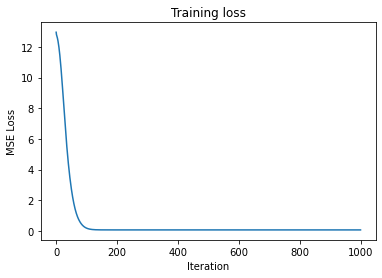

In [74]:
optimizer = optim.Adam(net.parameters(), lr=0.002) 
criterion = nn.MSELoss()

model_loss = [];

for epoch in range(1000):
    running_loss = 0.0 
    
    optimizer.zero_grad()
    
    output1, output2 = net(t_data_in_train) # remember that our model has two outputs now
    loss1 = criterion(output1, t_data_out_train[:,0,:]) # define the loss separately for each output
    loss2 = criterion(output2, t_data_out_train[:,1,:])
    loss = loss1+loss2 # and then combine the two losses so that you can backpropagate weights given the overall MSE
    loss.backward()
    optimizer.step()
    
    model_loss.append(loss.item())
    
    running_loss += loss.item()
    if epoch % 100 == 99:          
        print(running_loss/100)    
        running_loss = 0.0
print('Finished Training')


plt.plot(model_loss)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.show()

### Ex4.Step5: Test the network on training data
As before, we can test the accuracy of our model on new training data. Let's visualize the accuracy of our predictions for the two output channels in separate plots: 

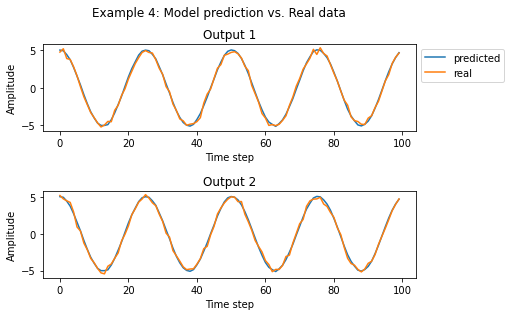

In [123]:
# model output:
model_out1, model_out2 = net(t_data_in_test)

model_out1 = model_out1.view(-1).detach().numpy() 
model_out2 = model_out2.view(-1).detach().numpy() 

# real output:
test_out1 = t_data_out_test.detach().numpy()[0] # first output feature
test_out2 = t_data_out_test.detach().numpy()[1] # second output feature

# plot the two output results:
plt.subplot(211)
plt.tight_layout(h_pad=5) # keep the subplots from overlapping
plt.plot(model_out1)
plt.plot(test_out1)
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.title('Output 1')
plt.legend(['predicted', 'real'], bbox_to_anchor=(1,1), loc="upper left")

plt.subplot(212)
plt.plot(model_out2)
plt.plot(test_out2)
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.title('Output 2')


plt.suptitle('Example 4: Model prediction vs. Real data')
plt.subplots_adjust(top=0.85) # keep the overall title from overlapping on subplot titles
plt.show()

In [124]:
print('Test error for output 1 is: ', mean_squared_error(model_out1, test_out[0:100]))
print('Test error for output 2 is: ', mean_squared_error(model_out2, test_out[100:]))

Test error for output 1 is:  0.0603113888528037
Test error for output 2 is:  0.06781691936197845


Armed with the knowledge above, you can now train neural networks of arbirary input and output size! An important tool to keep in your belt is regularization, which keeps your network from "memorizing" the behavior of the test data, leaving it too brittle to perform well on test data.

# Example 5: Using dropout to prevent overfitting 
A dropout layer is a way to prevent overfitting to the training data. During model training, some of the neuron weights will be randomly set to zero. A given neuron's probability of being set to zero is P (which we'll set to P=0.2, but feel free to tinker with the values). Other ways of preventing overfitting are: L1 (Lasso) and L2 (Ridge) regularization, batch normalization, or early stopping.

We'll use the same data as before, so we can skip steps 1 and 2 and jump straight to step 3: building the network.

### Ex5.Step3: Building the network
A tip: the dropout layer cannot be the very last thing in the forward method, because your output signal will be zero 20% of the time. I'm sure it seems obvious now that I'm saying it, but this took me a long time to troubleshoot. 

In [134]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(200,5)  
        self.fc2 = nn.Linear(5,10)   
        self.fc3 = nn.Linear(10,100) 
        self.dropout = nn.Dropout(p=0.2) # we'll make the probability of a hidden layer dropping out equal to 0.2
        
          
    def forward(self, x):
        x1 = x.view(x.size(0),-1)  
        x2 = x.view(x.size(0),-1) 
        
        x1 = F.relu(self.fc1(x1))    
        x2 = F.relu(self.fc1(x2)) 
        
        x1 = F.relu(self.fc2(x1))
        x2 = F.relu(self.fc2(x2))
        
        # now, we include a dropout layer right before our last fully-connected layer
        x1 = self.fc3(self.dropout(x1))             
        x2 = self.fc3(self.dropout(x2))
        return x1, x2
        
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=200, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=100, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Ex5.Step4: Training the network 
We're training the network in the exact same way as we did in Example 4. 

0.044402653495148436
0.030057240976866823
0.021265216450710982
0.021625002777596346
0.0214774295985967
0.012712619361653693
0.020156264340009198
0.014185546041536656
0.011283979620676088
0.019488254832519595
Finished Training


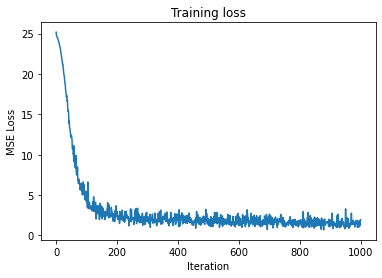

In [135]:
optimizer = optim.Adam(net.parameters(), lr=0.002) 
criterion = nn.MSELoss()

model_loss = [];

for epoch in range(1000):
    running_loss = 0.0 
    
    optimizer.zero_grad()
    
    output1, output2 = net(t_data_in_train) 
    loss1 = criterion(output1, t_data_out_train[:,0,:]) 
    loss2 = criterion(output2, t_data_out_train[:,1,:])
    loss = loss1+loss2 
    loss.backward()
    optimizer.step()
    
    model_loss.append(loss.item())
    
    running_loss += loss.item()
    if epoch % 100 == 99:          
        print(running_loss/100)    
        running_loss = 0.0
print('Finished Training')


plt.plot(model_loss)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.show()

See how the training loss is much noisier after it stabilizes? That's due to the randomness of some neurons still being dropped out every once in a while, making the net's performance marginally better or worse each time.
### Ex5.Step5: Test the network 
And the best part:

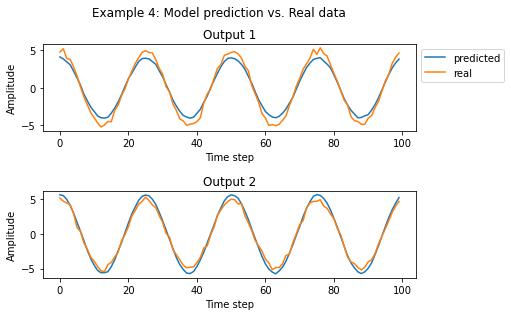

In [136]:
# model output:
model_out1, model_out2 = net(t_data_in_test)

model_out1 = model_out1.view(-1).detach().numpy() 
model_out2 = model_out2.view(-1).detach().numpy() 

# real output:
test_out1 = t_data_out_test.detach().numpy()[0] # first output feature
test_out2 = t_data_out_test.detach().numpy()[1] # second output feature

# plot the two output results:
plt.subplot(211)
plt.tight_layout(h_pad=5) # keep the subplots from overlapping
plt.plot(model_out1)
plt.plot(test_out1)
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.title('Output 1')
plt.legend(['predicted', 'real'], bbox_to_anchor=(1,1), loc="upper left")

plt.subplot(212)
plt.plot(model_out2)
plt.plot(test_out2)
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.title('Output 2')


plt.suptitle('Example 4: Model prediction vs. Real data')
plt.subplots_adjust(top=0.85) # keep the overall title from overlapping on subplot titles
plt.show()

In [137]:
print('Test error for output 1 is: ', mean_squared_error(model_out1, test_out[0:100]))
print('Test error for output 2 is: ', mean_squared_error(model_out2, test_out[100:]))

Test error for output 1 is:  0.5181717897003432
Test error for output 2 is:  0.2766196697161404


Using the dropout layer seems  to have decreased our model's performance. That's not necessarily a bad thing: remember that in all these examples, we've only used a single-batch test input. In practice, we'd want a model to generalize to many different samples of unseen data, so to truly evaluate its performance, we'd need to take the average of its ability to predict many test sets. 

Also, there's a good degree of randomness here: if you try reinitializing the network (zeroing out the learned weights) and train it again, there's a chance that the MSE will be lower, and our model will predict the test data well. Try it for yourself to get an intuition for why someone might train many iterations of the same kind of model in parallel.   

There are some other regularization techniques (Lasso, Ridge, ElasticNet) that could be more effective here. 